# ASTGCN

In [14]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from typing import Optional, List, Union
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj
from torch_geometric_temporal.nn.attention import ASTGCN 

In [19]:
def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size,
                            shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    filename = '/Users/varun/Desktop/finalYear/code/data/peMSD4/PEMS04_r1_d0_w0_astcgn'

    file_data = np.load(filename + '.npz')
    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor) # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor) # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std

In [20]:
graph_signal_matrix_filename = '/Users/varun/Desktop/finalYear/code/PEMS04.npz'
batch_size = 32
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size)

train: torch.Size([10181, 307, 1, 12]) torch.Size([10181, 307, 12])
val: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])
test: torch.Size([3394, 307, 1, 12]) torch.Size([3394, 307, 12])


In [5]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:
        
        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

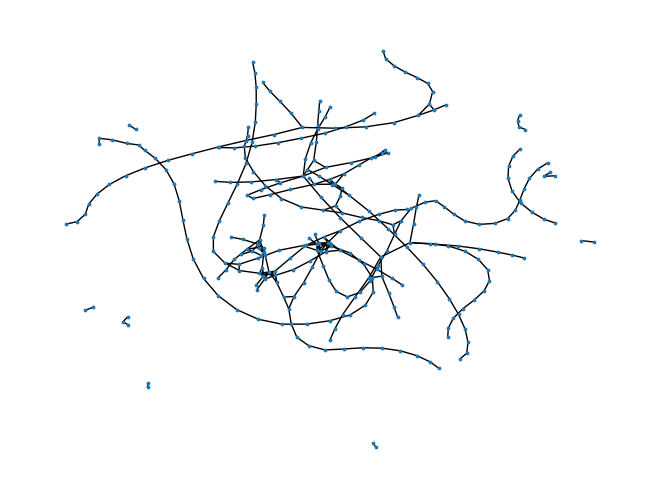

In [6]:
id_filename = None
adj_filename = '/Users/varun/Desktop/finalYear/code/data/PEMS04.csv'
num_of_vertices = 307
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename) #  adj_mx and distance_mx (307, 307)

rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist())
edge_index_data = torch.LongTensor(np.array([rows, cols]))

In [7]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = num_of_hours
num_for_predict = 12
len_input = 12

net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices)

print(net)

ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(12, 12, kernel_size=(1, 64), strid

In [13]:
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

print('Net\'s state_dict:')
total_param = 0
for param_tensor in net.state_dict():
    print(param_tensor, '\t', net.state_dict()[param_tensor].size(), '\t', net.state_dict()[param_tensor].device)
    total_param += np.prod(net.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
_blocklist.0._temporal_attention._U1 	 torch.Size([307]) 	 cpu
_blocklist.0._temporal_attention._U2 	 torch.Size([1, 307]) 	 cpu
_blocklist.0._temporal_attention._U3 	 torch.Size([1]) 	 cpu
_blocklist.0._temporal_attention._be 	 torch.Size([1, 12, 12]) 	 cpu
_blocklist.0._temporal_attention._Ve 	 torch.Size([12, 12]) 	 cpu
_blocklist.0._spatial_attention._W1 	 torch.Size([12]) 	 cpu
_blocklist.0._spatial_attention._W2 	 torch.Size([1, 12]) 	 cpu
_blocklist.0._spatial_attention._W3 	 torch.Size([1]) 	 cpu
_blocklist.0._spatial_attention._bs 	 torch.Size([1, 307, 307]) 	 cpu
_blocklist.0._spatial_attention._Vs 	 torch.Size([307, 307]) 	 cpu
_blocklist.0._chebconv_attention._weight 	 torch.Size([3, 1, 64]) 	 cpu
_blocklist.0._chebconv_attention._bias 	 torch.Size([64]) 	 cpu
_blocklist.0._time_convolution.weight 	 torch.Size([64, 64, 1, 3]) 	 cpu
_blocklist.0._time_convolution.bias 	 torch.Size([64]) 	 cpu
_blocklist.0._residual_convolution.weight 	 torch.Size([64, 1, 1,

In [14]:
def masked_mae(preds, labels, null_val=np.nan):
    if np.isnan(null_val):
        mask = ~torch.isnan(labels)
    else:
        mask = (labels != null_val)
    mask = mask.float()
    mask /= torch.mean((mask))
    mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
    loss = torch.abs(preds - labels)
    loss = loss * mask
    loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
    return torch.mean(loss)

In [26]:
masked_flag=0
criterion = nn.L1Loss()
criterion_masked = masked_mae
loss_function = 'mse'

metric_method = 'unmask'
missing_value=0.0


if loss_function=='masked_mse':
    criterion_masked = masked_mse    
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss()
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss()
    masked_flag= 0

In [20]:
def compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, epoch, edge_index_data, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param epoch: int, current epoch
    :param limit: int, optional limit on number of batches to process
    :return: val_loss
    '''
    net.eval()  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # number of batches
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('Validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
    return validation_loss


In [21]:
global_step = 0
best_epoch = 0
best_val_loss = np.inf
start_time= time()

In [23]:
# Train model
for epoch in range(20):
    params_filename = os.path.join('./', 'epoch_%s.params' % epoch)
    masked_flag = 1
    
    if masked_flag:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion_masked, masked_flag, missing_value, epoch, edge_index_data)
    else:
        val_loss = compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, epoch, edge_index_data)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch

    net.train()  # Ensure dropout layers are in train mode

    for batch_index, batch_data in enumerate(train_loader):
        encoder_inputs, labels = batch_data  # encoder_inputs torch.Size([32, 307, 1, 12]), labels torch.Size([32, 307, 12])
        optimizer.zero_grad()
        outputs = net(encoder_inputs, edge_index_data)  # torch.Size([32, 307, 12])

        if masked_flag:
            loss = criterion_masked(outputs, labels, missing_value)
        else:
            loss = criterion(outputs, labels)
            
        loss.backward()
        optimizer.step()
        training_loss = loss.item()
        global_step += 1

        if global_step % 200 == 0:
            print('Global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))


Validation batch 1 / 107, loss: 210.27
Validation batch 101 / 107, loss: 266.04
Global step: 200, training loss: 98.40, time: 406.07s
Global step: 400, training loss: 49.63, time: 670.38s
Validation batch 1 / 107, loss: 46.33
Validation batch 101 / 107, loss: 64.61


KeyboardInterrupt: 